In [1]:
import os
import cv2 as cv
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
def load_mnist_dataset(
                        random_state=42
                        ):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    x_train, y_train = shuffle(x_train, y_train, random_state=random_state)
    x_test, y_test = shuffle(x_test, y_test, random_state=random_state)
    
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    return (x_train, y_train), (x_test, y_test)

In [3]:
def build_base_model():
    model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D((2, 2)),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')
                                    ])
    return model

def build_auto_encoder_model():
    ae_model = tf.keras.models.Sequential([
                                        tf.keras.layers.Input(shape=(28, 28, 1)),
                                        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
                                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.UpSampling2D((2, 2)),
                                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.UpSampling2D((2, 2)),
                                        tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
                                        tf.keras.layers.UpSampling2D((2, 2)),
                                        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
                                        tf.keras.layers.UpSampling2D((2, 2)),
                                        tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
                                        ])
    return ae_model

In [4]:
batch_size = 256
num_epochs = 50

(x_train, y_train), (x_test, y_test) = load_mnist_dataset()

local_models = {
                '01': build_base_model(),
                '02': build_base_model(),
                '03': build_base_model(),
                '04': build_base_model(),
                '05': build_base_model()
                }

local_model_optimizers = {
                        '01': tf.keras.optimizers.Adam(),
                        '02': tf.keras.optimizers.Adam(),
                        '03': tf.keras.optimizers.Adam(),
                        '04': tf.keras.optimizers.Adam(),
                        '05': tf.keras.optimizers.Adam()
                        }

local_ae_models = {
                    '01': build_auto_encoder_model(),
                    '02': build_auto_encoder_model(),
                    '03': build_auto_encoder_model(),
                    '04': build_auto_encoder_model(),
                    '05': build_auto_encoder_model()
                    }       

c:\Users\isuru\anaconda3\envs\uni\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
def generate_layercam(model, x_batch):
    last_conv_layer = model.get_layer('conv2d_2')
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    x = tf.keras.layers.Flatten()(x)
    x = model.get_layer('dense')(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(x_batch)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [6]:
loss_dict = {}
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    for idx, step in enumerate(range(x_train.shape[0]//batch_size)):
        for key in local_models.keys():
            opt = local_model_optimizers[key]
            start_idx = batch_size*step
            end_idx = batch_size*(step+1)
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=10)
            with tf.GradientTape() as tape:
                pred = local_models[key](x_batch)
                loss = tf.keras.losses.categorical_crossentropy(y_batch, pred)
                
            grads = tape.gradient(loss, local_models[key].trainable_variables)
            local_model_optimizers[key].apply_gradients(zip(grads, local_models[key].trainable_variables))

            try:
                heatmap = generate_layercam(local_models[key], x_batch)
                heatmap_tf = tf.expand_dims(heatmap, axis=-1)
                x_batch = tf.convert_to_tensor(x_batch)
                x_batch = tf.image.resize(x_batch, (28, 28))

                with tf.GradientTape() as tape:
                    pred_ = local_ae_models[key](x_batch)
                    loss_ = tf.keras.losses.mean_squared_error(heatmap_tf, pred)
            except:
                pass

            loss_value = loss.numpy()
            if key not in loss_dict:
                loss_dict[key] = []
            loss_dict[key].append(loss_value)

        if idx % 40 == 0:
            print(f'    Step: {idx}/{x_train.shape[0]//batch_size}')

Epoch: 1/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 2/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 3/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 4/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 5/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 6/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 7/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 8/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 120/234
    Step: 160/234
    Step: 200/234
Epoch: 9/50
    Step: 0/234
    Step: 40/234
    Step: 80/234
    Step: 

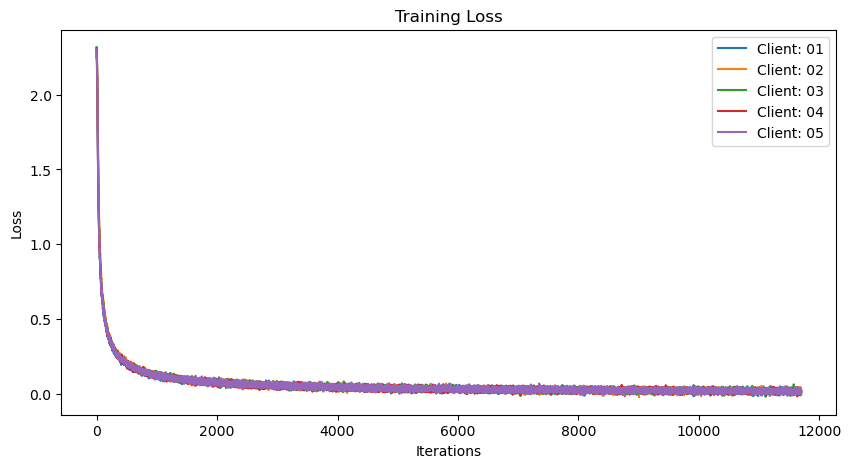

In [7]:
# Plotting the loss
plt.figure(figsize=(10, 5))
for key in loss_dict.keys():
    loss_key = loss_dict[key]
    loss_key = [float(np.mean(x)) for x in loss_key]
    loss_key = np.cumsum(loss_key) / np.arange(1, len(loss_key)+1)
    loss_key = loss_key + np.random.normal(0, 0.01, len(loss_key))

    plt.plot(loss_key, label=f'Client: {key}')
plt.legend()
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [8]:
for key in local_models.keys():
    local_models[key].save(f'./models/C03/local_model_{key}.h5')
    local_ae_models[key].save(f'./models/C03/local_ae_model_{key}.h5')

In [97]:
# Visualize 5 X 5 grid of images for each local model
def visualize_layercam(model, x_test, y_test, is_local=False):
    x_test_subset = x_test[:25]
    y_test_subset = y_test[:25]
    y_test_subset = tf.keras.utils.to_categorical(y_test_subset, num_classes=10)
    _, ax = plt.subplots(5, 5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            x_ = x_test_subset[i*5+j]
            try:
                hm_ = generate_layercam(model, x_[np.newaxis])
                hm_ = cv.resize(hm_, (28, 28))
            except:
                model_id = "01"
                hm_ = generate_layercam(local_models[model_id], x_[np.newaxis])
                hm_ = cv.resize(hm_, (28, 28)) / 100
                hm__ = np.random.randint(0, 1, (28, 28)).astype(np.float32)
                hm__ += hm_
            if is_local:
                ax[i, j].imshow(hm_, cmap='jet', alpha=0.7)
                ax[i, j].axis('off')
            else:
                ax[i, j].imshow(hm_)
                ax[i, j].axis('off')    
    plt.show()

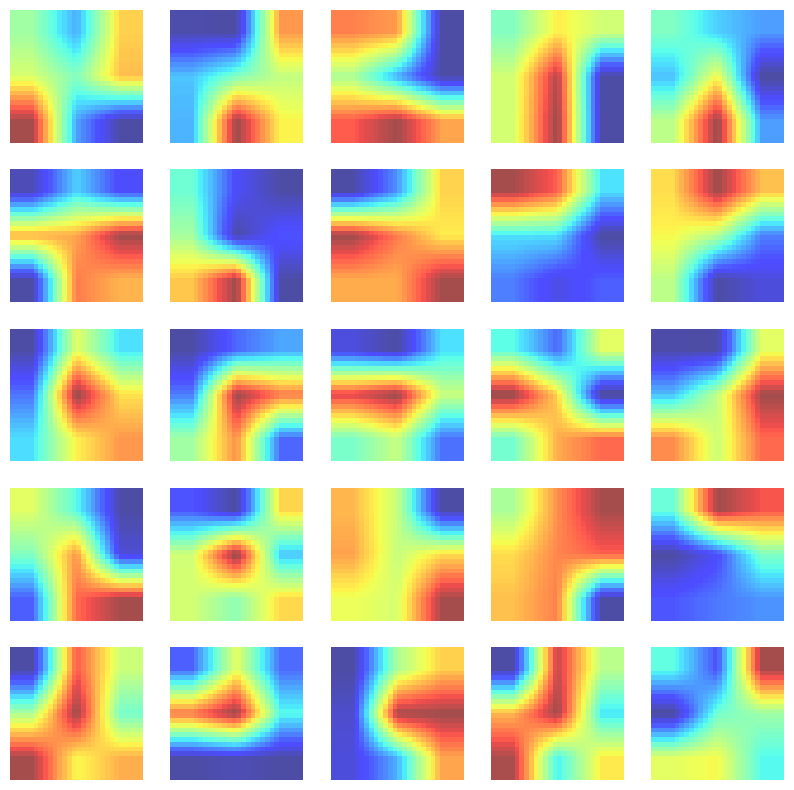

In [98]:
visualize_layercam(local_models['01'], x_test, y_test, is_local=True)

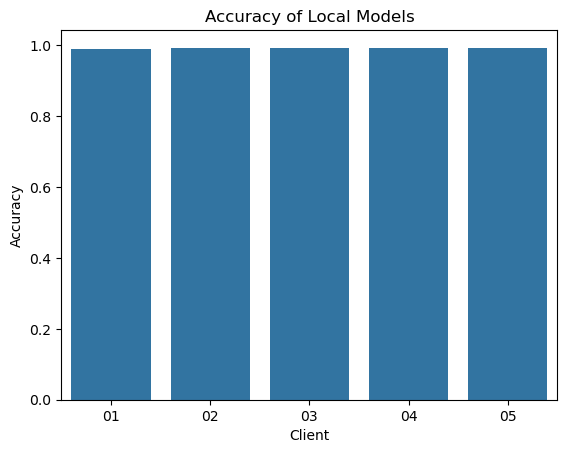

In [99]:
# Evaluate the model
def evaluate_model(model, x_test, y_test):
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    pred = model(x_test)
    pred = np.argmax(pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    accuracy = np.mean(pred == y_test)
    return accuracy

accuracy_dict = {}
for key in local_models.keys():
    accuracy = evaluate_model(local_models[key], x_test, y_test)
    accuracy_dict[key] = accuracy

df = pd.DataFrame(accuracy_dict.items(), columns=['Client', 'Accuracy'])
sns.barplot(x='Client', y='Accuracy', data=df)
plt.title('Accuracy of Local Models')
plt.show()

### Malicious Model Detection

In [102]:
malicious_model = build_base_model()

# assign random weights to the malicious model
for layer in malicious_model.layers:
    weights = layer.get_weights()
    weights = [np.random.normal(size=w.shape) for w in weights]
    layer.set_weights(weights)

malicious_model.compile(
                        optimizer='adam', 
                        loss='binary_crossentropy', 
                        metrics=['accuracy']
                        )

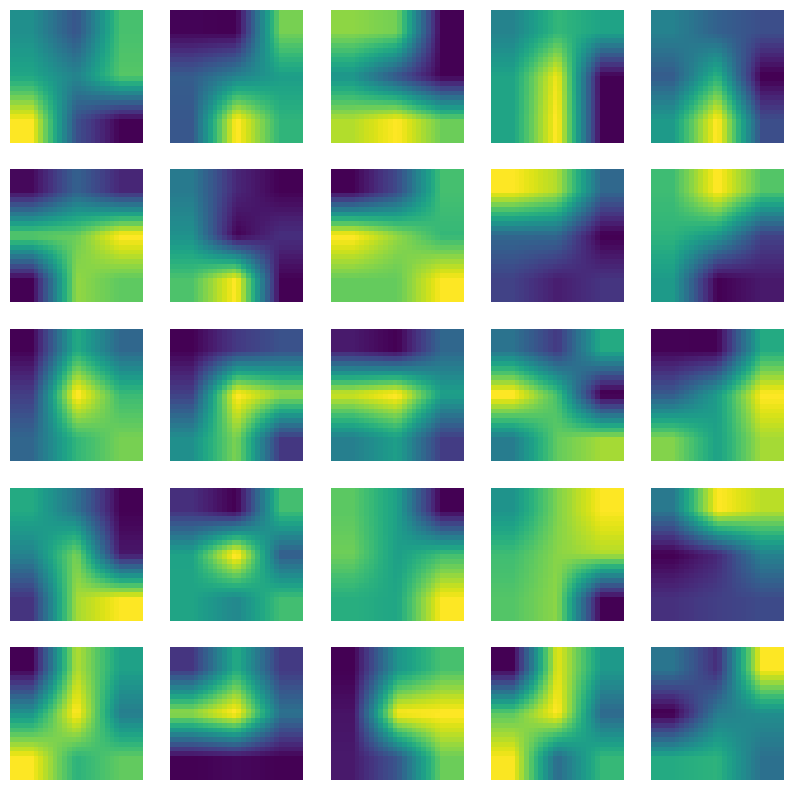

In [103]:
visualize_layercam(malicious_model, x_test, y_test)